#### Import libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

/content/drive/MyDrive/NN


#### Data preprocessing

In [32]:
class Dataset:
    def __init__(self, path):
        self.original_data = pd.read_csv(path)
        self.data = pd.read_csv(path)

    def show(self):
        print(self.data.head())

    def convert_to_numbers(self):
        for col in ['SteamDir', 'RedLightDir1', 'RedLightDir2']:
            one_hot = pd.get_dummies(self.data[col], prefix=col)
            self.data = self.data.drop(col,axis = 1)
            self.data = self.data.join(one_hot)

        labels = self.data['FireAlarm']
        self.data = self.data.drop('FireAlarm',axis = 1)
        self.data = self.data.join(labels)

        cat_columns = self.data.select_dtypes(['object']).columns
        self.data[cat_columns] = self.data[cat_columns].apply(lambda x: x.astype('category'))
        self.data[cat_columns] = self.data[cat_columns].apply(lambda x: x.cat.codes)

    def missing_values(self, method):
        self.data = self.data[self.data['FireAlarm'].notna()]
        self.data = self.data.reset_index(drop=True)
        missing_value = {'col_name':[], 'missing_count':[], 'replaced_value':[]}
        for (column_name, column_data) in self.data.iteritems():
            missing_values_count = column_data.isna().sum()
            missing_value['col_name'].append(column_name[:16])
            missing_value['missing_count'].append(missing_values_count)
            if method == 'mode':
                value = self.data[column_name].mode().item()
            elif method == 'nearest':
                pass
            self.data[column_name].fillna(value=value, inplace=True)
            missing_value['replaced_value'].append(value)
        plt.figure(figsize=(30,5))
        pps = plt.bar(missing_value['col_name'], missing_value['missing_count'], color='coral')
        for i, p in enumerate(pps):
            plt.text(x=p.get_x() + p.get_width()/3, y=p.get_height()+1, s=missing_value['replaced_value'][i])
        plt.tight_layout()
        plt.title('missing values count and replaced values')
        plt.xlabel('columns')
        plt.ylabel('# of missing values')
        print('Missing Values:')
        plt.show()
    
    def normalize(self, method):
        if method == 'standard':
            self.data[self.data.columns.difference(['FireAlarm'])] = self.data[self.data.columns.difference(['FireAlarm'])].apply(lambda x: (x-x.mean())/x.std())
        elif method == 'min-max':
            self.data[self.data.columns.difference(['FireAlarm'])] = self.data[self.data.columns.difference(['FireAlarm'])].apply(lambda x: (x-x.min())/(x.max()-x.min()))

    def outliers(self):
        k_means = KMeans(n_clusters=2, random_state=0).fit(self.data)
        centers = k_means.cluster_centers_
        outlier_indexes = []
        d = []
        for index, row in self.data.iterrows():
            center = k_means.labels_[index]
            dist = np.linalg.norm(row - center)
            d.append(dist)
            if dist > 15:
                outlier_indexes.append(index)
        plt.hist(d)
        plt.title('distance to center')
        print('outliers:')
        plt.show()
        print('number of outliers: ' + str(len(outlier_indexes)))
        self.data.drop(index=outlier_indexes, axis=1, inplace=True)
        
    def split_data(self):
        self.train_data = self.data.sample(frac=0.70,random_state=200)
        other_data = self.data.drop(self.train_data.index)
        self.val_data = other_data.sample(frac=0.5,random_state=123)
        self.test_data = other_data.drop(self.val_data.index)
        self.train_data, self.val_data, self.test_data = self.train_data.to_numpy(), self.val_data.to_numpy(), self.test_data.to_numpy()


Missing Values:


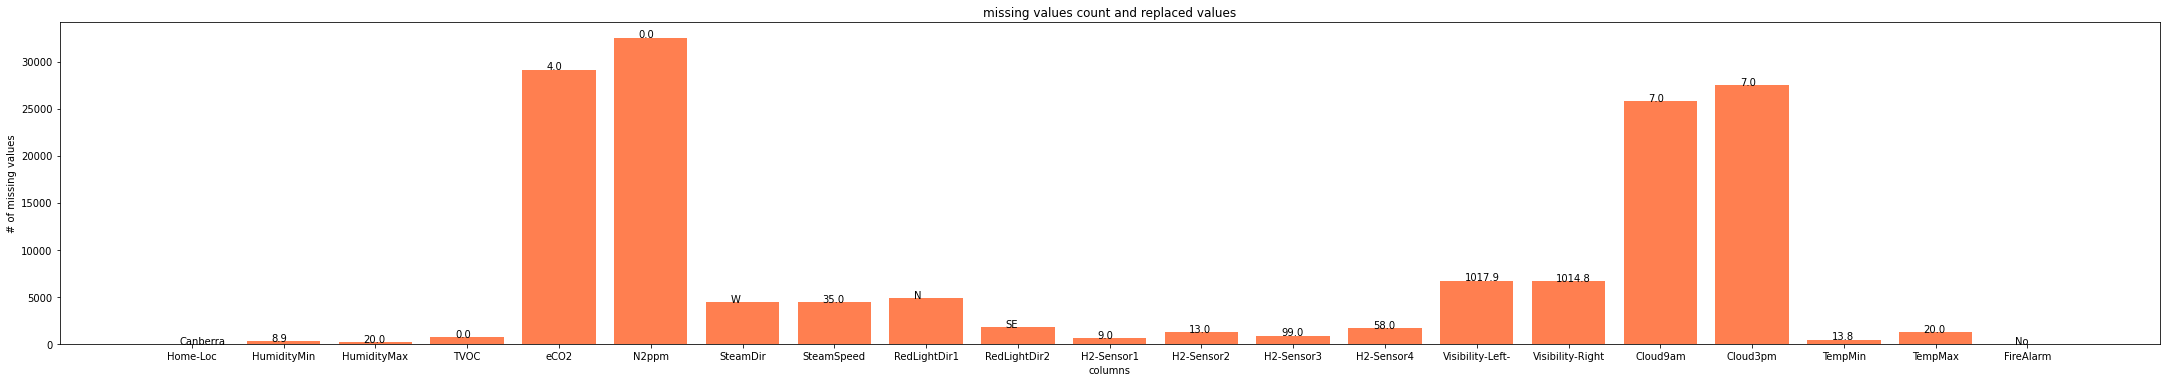

outliers:


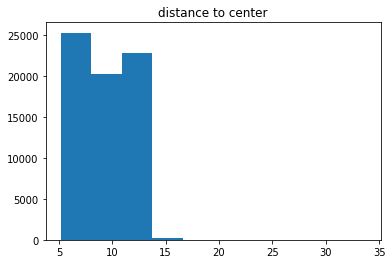

number of outliers: 121


In [33]:
dataset = Dataset('Fire.csv')
# dataset.show()
dataset.missing_values(method='mode') 
dataset.convert_to_numbers()
dataset.normalize(method='standard')
dataset.outliers()
dataset.split_data()

#### Feed Forward model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

class FeedForward(nn.Module):
    def __init__(self, data_dim, activations, hidden_dims):
        super(FeedForward, self).__init__()
        self.activations = activations
        hidden_dims = [data_dim] + hidden_dims
        self.layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            if hidden_dims[i] == 0:
                self.layers.append(nn.Dropout(p=0.1))
            elif hidden_dims[i-1] == 0:
                self.layers.append(nn.Linear(hidden_dims[i-2], hidden_dims[i]))
            else:
                self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i])) 
        
        if hidden_dims[-1] != 0:
            self.layers.append(nn.Linear(hidden_dims[-1], 1))
        else:
            self.layers.append(nn.Linear(hidden_dims[-2], 1))
        self.activations.append(None)         

    def forward(self, input):
        output = input
        for i in range(len(self.layers)):
            layer_out = self.layers[i](output)
            if self.activations[i]:
                output = self.activations[i](layer_out)
            else:
                output = layer_out
        return output

#### Training model

In [43]:
def train_model(dataset, activations, hidden_dims, num_epochs, batch_size):
    train_loader = DataLoader(dataset=dataset.train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=dataset.val_data, batch_size=batch_size, shuffle=False)

    model = FeedForward(dataset.train_data.shape[1]-1, activations, hidden_dims)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    all_train_loss = []
    all_train_acc = []
    all_val_loss = []
    all_val_acc = []     
    for epoch in range(num_epochs):
        train_bar = tqdm(train_loader)
        train_predicted = []
        train_labels = []
        train_acc_list = []
        train_losses = []
        for iter, data in enumerate(train_bar):
            labels = torch.as_tensor(data[:, -1]).to(torch.float32)
            data = torch.as_tensor(data[:, :-1]).to(torch.float32)
            outputs = model(data)
            outputs = outputs.flatten()
            predicted = torch.round(nn.Sigmoid()(outputs))
            # predicted = outputs.argmax(-1)
            # print(predicted)
            # print(labels)
            # print("########")
            train_predicted.extend(predicted.to(int).tolist())
            train_labels.extend(labels.tolist())
            train_acc_list.extend((predicted==labels).to(int).tolist())
            optimizer.zero_grad()
            # print(outputs)
            # print(labels)
            train_loss = criterion(outputs, labels)
            train_losses.append(train_loss.item())
            train_loss.backward()
            optimizer.step()
            train_acc = sum(train_acc_list)/len(train_acc_list)
            train_loss = sum(train_losses)/len(train_losses)
            
            if iter%200 == 0:
                val_labels = []
                val_predicted = []
                val_acc_list = []
                val_losses = []
                for iter, data in enumerate(val_loader):
                    labels = torch.as_tensor(data[:, -1]).to(torch.float32)
                    data = torch.as_tensor(data[:, :-1]).to(torch.float32)
                    outputs = model(data) 
                    outputs = outputs.flatten()
                    predicted = torch.round(nn.Sigmoid()(outputs))
                    val_predicted.extend(predicted.to(int).tolist())
                    val_labels.extend(labels.tolist())
                    val_acc_list.extend((predicted==labels).to(int).tolist())
                    val_loss = criterion(outputs, labels)
                    val_losses.append(val_loss.item())
                val_acc = sum(val_acc_list)/len(val_acc_list)
                val_loss = sum(val_losses)/len(val_losses)

                all_train_loss.append(train_loss)
                all_train_acc.append(train_acc)
                all_val_loss.append(val_loss)
                all_val_acc.append(val_acc)
                val_confusion_mat = metrics.confusion_matrix(val_labels, val_predicted)

            train_bar.set_postfix({'train loss': train_loss, 'train acc': train_acc, 'val loss': val_loss, 'val acc': val_acc})
            train_bar.set_description('epoch {}'.format(epoch))
            train_confusion_mat = metrics.confusion_matrix(train_labels, train_predicted)
    return model, all_train_loss, all_train_acc, all_val_loss, all_val_acc, train_confusion_mat, val_confusion_mat

def test_model(model, dataset, batch_size):
    model.eval()
    test_loader = DataLoader(dataset=dataset.test_data, batch_size=batch_size, shuffle=False)
    criterion = nn.BCEWithLogitsLoss()

    test_predicted = []
    test_labels = []
    test_losses = []
    test_acc_list = []
    for iter, data in enumerate(test_loader):
        labels = torch.as_tensor(data[:, -1]).to(torch.float32)
        data = torch.as_tensor(data[:, :-1]).to(torch.float32)
        outputs = model(data) 
        outputs = outputs.flatten()
        predicted = torch.round(nn.Sigmoid()(outputs))
        test_predicted.extend(predicted.to(int).tolist())
        test_labels.extend(labels.tolist())
        test_acc_list.extend((predicted==labels).to(int).tolist())
        test_loss = criterion(outputs, labels)
        test_losses.append(test_loss.item())
    test_loss = sum(test_losses)/len(test_losses)
    test_acc = sum(test_acc_list)/len(test_acc_list)
    confusion_mat = metrics.confusion_matrix(test_labels, test_predicted)
    return test_loss, test_acc, confusion_mat

def plot_test_info(test_loss, test_acc, confusion_mat):
    print('test loss: ' + str(test_loss))
    print('test accuracy: ' + str(test_acc))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels=[False, True])
    cm_display.plot()
    cm_display.ax_.set_title('confusion matrix in test data')
    plt.show()
    
def plot_train_info(train_loss, train_acc, val_loss, val_acc, train_confusion_mat, val_confusion_mat):
    figure, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].plot(train_loss, label='train loss')
    axis[0].plot(val_loss, label='val loss')
    axis[0].set_title("train and validation loss")
    axis[0].set_xlabel("per 100 iterations")
    axis[0].set_ylabel("loss")
    handles, labels = axis[0].get_legend_handles_labels()
    axis[0].legend(handles, labels)

    axis[1].plot(train_acc, label='train accuracy')
    axis[1].plot(val_acc, label='val accuracy')
    axis[1].set_title("train and validation accuracy")
    axis[1].set_xlabel("per 100 iterations")
    axis[1].set_ylabel("accuracy")
    handles, labels = axis[1].get_legend_handles_labels()
    axis[1].legend(handles, labels)

    plt.tight_layout()
    plt.show()

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = train_confusion_mat, display_labels=[False, True])
    cm_display.plot()
    cm_display.ax_.set_title('confusion matrix in train data')
    plt.show()
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_confusion_mat, display_labels=[False, True])
    cm_display.plot()
    cm_display.ax_.set_title('confusion matrix in validation data')
    plt.show()

#### Checking the linear separability of the data

epoch 4: 100%|██████████| 374/374 [00:15<00:00, 24.92it/s, train loss=0.393, train acc=0.837, val loss=0.389, val acc=0.842]


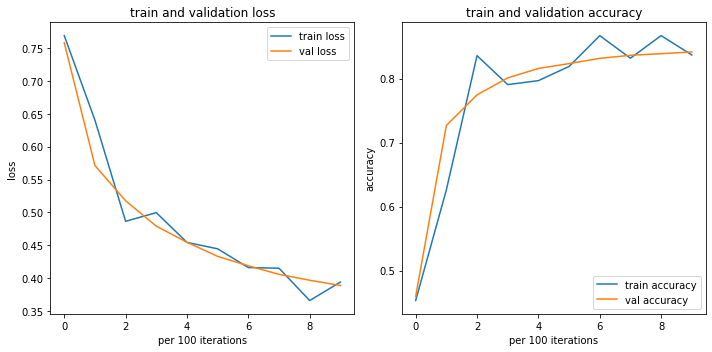

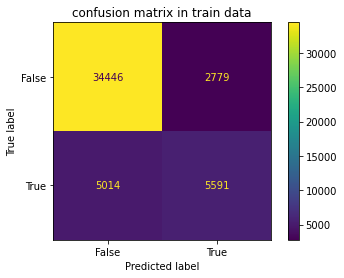

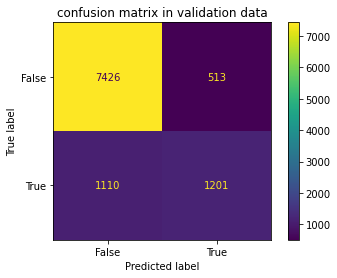

In [22]:
model, train_loss, train_acc, val_loss, val_acc, train_conf, val_conf = train_model(dataset=dataset, activations=[], hidden_dims=[], num_epochs=5, batch_size=128)
plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf, val_conf)

#### Find best parameters

In [23]:
all_params = [[64], [64, 64], [64, 64, 64], [128], [128, 128], [128, 128, 128], [64, 128], [128, 64], [128, 64, 64], [64, 128, 64], [64, 64, 128], [128, 128, 64], [128, 64, 128], [64, 128, 128],
              [8], [8, 8], [64, 8], [8, 64], [8, 64, 8], [64, 8, 8], [8, 8, 64], [8, 8, 8]]
for params in all_params:
    print(params)
    _, train_loss, train_acc, val_loss, val_acc, train_conf, val_conf = train_model(dataset=dataset, activations=[nn.ReLU() for _ in range(len(params))], hidden_dims=params, num_epochs=3, batch_size=128)
    print("######################")

[64]


epoch 2: 100%|██████████| 374/374 [00:15<00:00, 23.56it/s, train loss=0.352, train acc=0.847, val loss=0.354, val acc=0.845]


######################
[64, 64]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 23.07it/s, train loss=0.349, train acc=0.848, val loss=0.351, val acc=0.845]


######################
[64, 64, 64]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 23.26it/s, train loss=0.349, train acc=0.849, val loss=0.353, val acc=0.847]


######################
[128]


epoch 2: 100%|██████████| 374/374 [00:15<00:00, 23.75it/s, train loss=0.348, train acc=0.848, val loss=0.352, val acc=0.846]


######################
[128, 128]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 22.81it/s, train loss=0.345, train acc=0.851, val loss=0.349, val acc=0.846]


######################
[128, 128, 128]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 22.95it/s, train loss=0.344, train acc=0.852, val loss=0.351, val acc=0.846]


######################
[64, 128]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 23.17it/s, train loss=0.348, train acc=0.849, val loss=0.352, val acc=0.844]


######################
[128, 64]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 22.95it/s, train loss=0.346, train acc=0.85, val loss=0.353, val acc=0.846]


######################
[128, 64, 64]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 22.89it/s, train loss=0.346, train acc=0.85, val loss=0.35, val acc=0.845]


######################
[64, 128, 64]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 23.07it/s, train loss=0.348, train acc=0.849, val loss=0.352, val acc=0.847]


######################
[64, 64, 128]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 23.00it/s, train loss=0.347, train acc=0.85, val loss=0.351, val acc=0.847]


######################
[128, 128, 64]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 22.99it/s, train loss=0.345, train acc=0.85, val loss=0.35, val acc=0.846]


######################
[128, 64, 128]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 23.10it/s, train loss=0.345, train acc=0.85, val loss=0.353, val acc=0.844]


######################
[64, 128, 128]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 23.05it/s, train loss=0.345, train acc=0.85, val loss=0.351, val acc=0.846]


######################
[8]


epoch 2: 100%|██████████| 374/374 [00:15<00:00, 23.88it/s, train loss=0.364, train acc=0.842, val loss=0.362, val acc=0.844]


######################
[8, 8]


epoch 2: 100%|██████████| 374/374 [00:15<00:00, 23.95it/s, train loss=0.362, train acc=0.842, val loss=0.36, val acc=0.842]


######################
[64, 8]


epoch 2: 100%|██████████| 374/374 [00:15<00:00, 23.47it/s, train loss=0.35, train acc=0.849, val loss=0.351, val acc=0.847]


######################
[8, 64]


epoch 2: 100%|██████████| 374/374 [00:15<00:00, 23.39it/s, train loss=0.362, train acc=0.843, val loss=0.358, val acc=0.844]


######################
[8, 64, 8]


epoch 2: 100%|██████████| 374/374 [00:15<00:00, 23.55it/s, train loss=0.361, train acc=0.844, val loss=0.361, val acc=0.843]


######################
[64, 8, 8]


epoch 2: 100%|██████████| 374/374 [00:15<00:00, 23.72it/s, train loss=0.351, train acc=0.849, val loss=0.352, val acc=0.846]


######################
[8, 8, 64]


epoch 2: 100%|██████████| 374/374 [00:15<00:00, 23.62it/s, train loss=0.362, train acc=0.843, val loss=0.361, val acc=0.842]


######################
[8, 8, 8]


epoch 2: 100%|██████████| 374/374 [00:16<00:00, 23.27it/s, train loss=0.371, train acc=0.84, val loss=0.369, val acc=0.843]

######################


epoch 4: 100%|██████████| 374/374 [00:15<00:00, 24.86it/s, train loss=0.333, train acc=0.856, val loss=0.351, val acc=0.846]


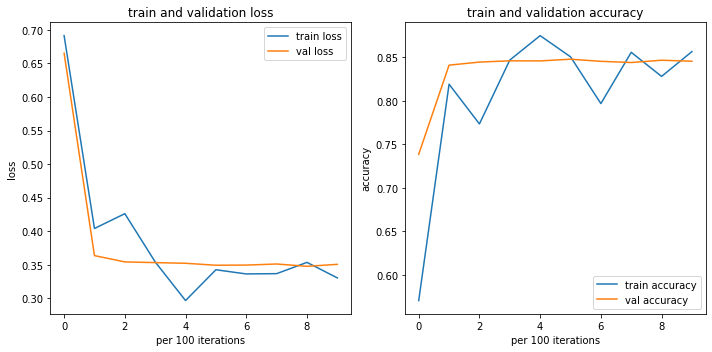

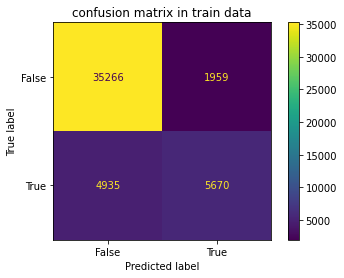

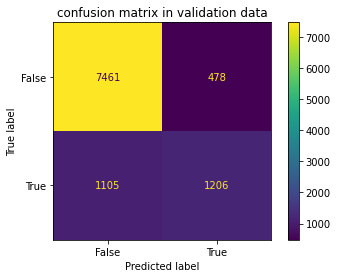

In [29]:
best_layers = [128, 128]
model, train_loss, train_acc, val_loss, val_acc, train_conf, val_conf = train_model(dataset=dataset, activations=[nn.ReLU(), nn.ReLU()], hidden_dims=best_layers, num_epochs=5, batch_size=128)
plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf, val_conf)

#### Checking activation functions

######################
activation: Sigmoid()


epoch 4: 100%|██████████| 374/374 [00:17<00:00, 21.02it/s, train loss=0.365, train acc=0.842, val loss=0.363, val acc=0.841]


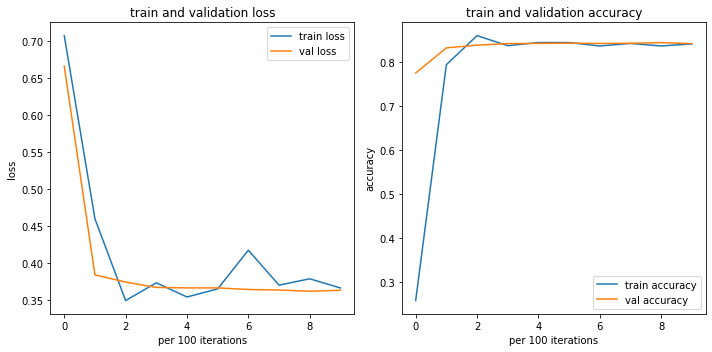

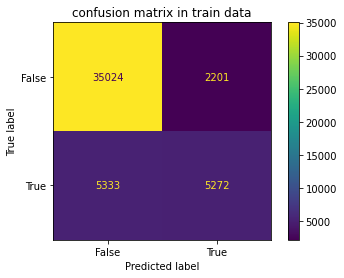

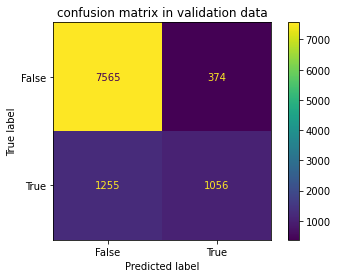

######################
activation: Tanh()


epoch 4: 100%|██████████| 374/374 [00:16<00:00, 22.39it/s, train loss=0.354, train acc=0.847, val loss=0.355, val acc=0.845]


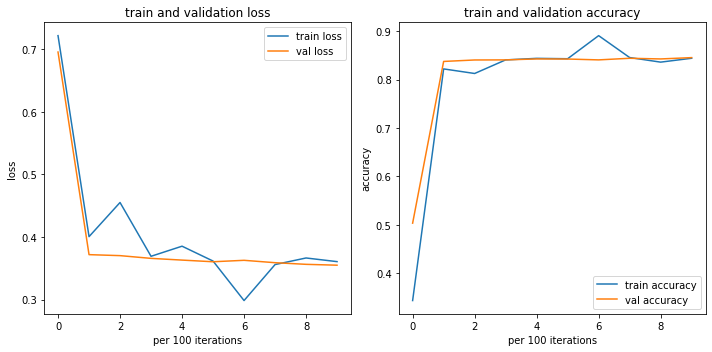

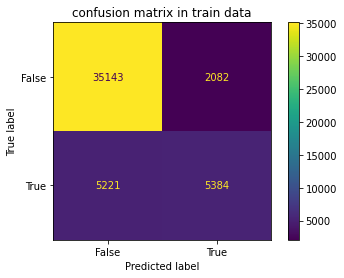

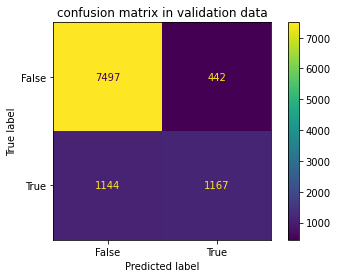

######################
activation: ReLU()


epoch 4: 100%|██████████| 374/374 [00:17<00:00, 21.90it/s, train loss=0.335, train acc=0.855, val loss=0.349, val acc=0.848]


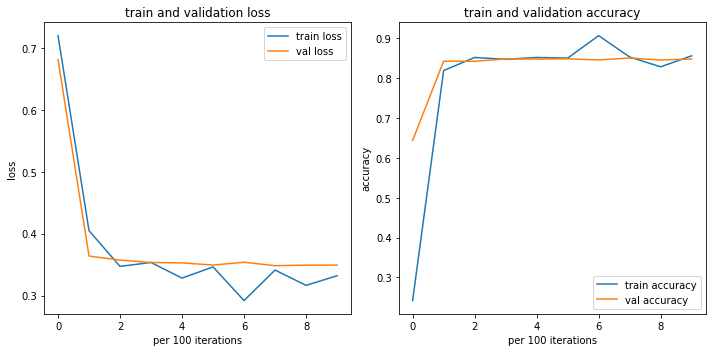

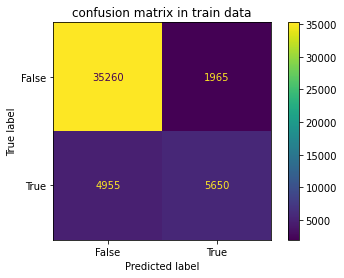

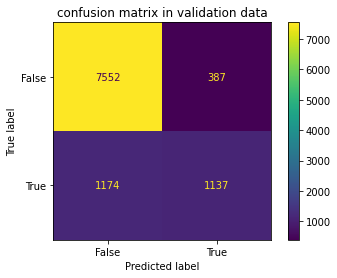

######################
activation: LeakyReLU(negative_slope=0.01)


epoch 4: 100%|██████████| 374/374 [00:17<00:00, 21.17it/s, train loss=0.333, train acc=0.856, val loss=0.345, val acc=0.849]


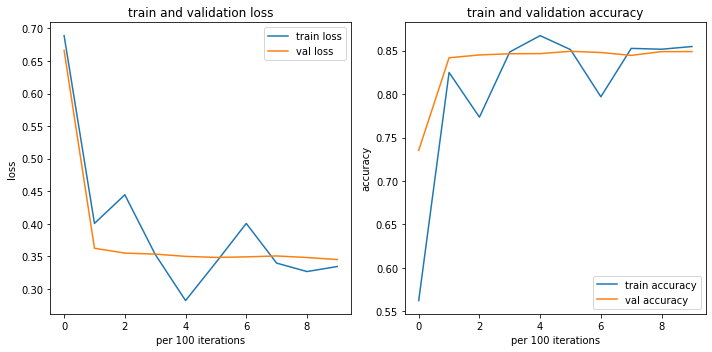

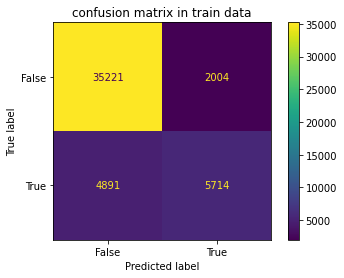

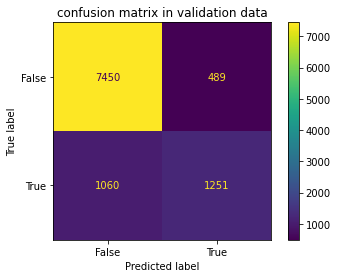

In [35]:
best_layers = [128, 128]
activations = [nn.Sigmoid(), nn.Tanh(), nn.ReLU(), nn.LeakyReLU()]
for activation in activations:
    print("######################")
    print('activation: ' + str(activation))
    _, train_loss, train_acc, val_loss, val_acc, train_conf, val_conf = train_model(dataset=dataset, activations=[activation for _ in range(len(best_layers))], hidden_dims=best_layers, num_epochs=5, batch_size=128)
    plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf, val_conf)


#### Checking batch size

batch size: 16


epoch 2: 100%|██████████| 2990/2990 [02:23<00:00, 20.89it/s, train loss=0.343, train acc=0.852, val loss=0.355, val acc=0.846]


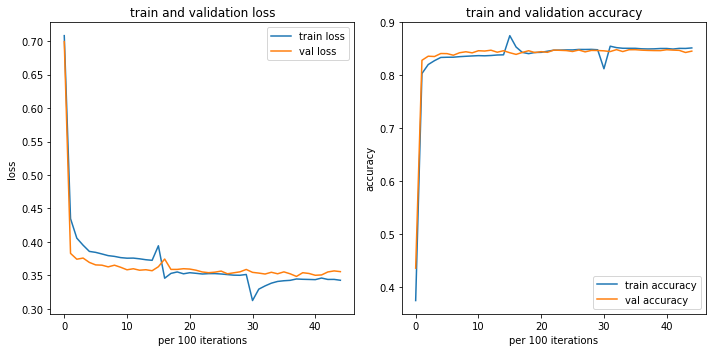

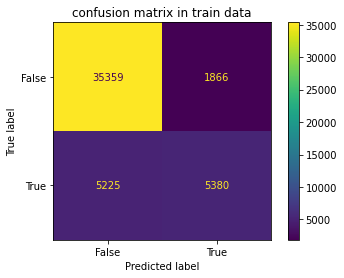

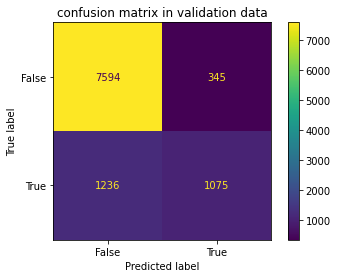

######################
batch size: 128


epoch 2: 100%|██████████| 374/374 [00:19<00:00, 19.68it/s, train loss=0.344, train acc=0.852, val loss=0.352, val acc=0.846]


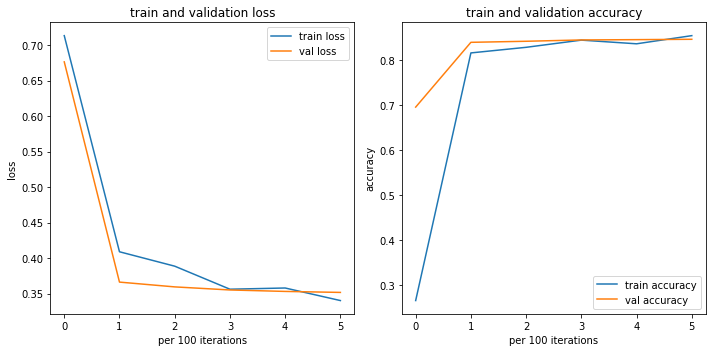

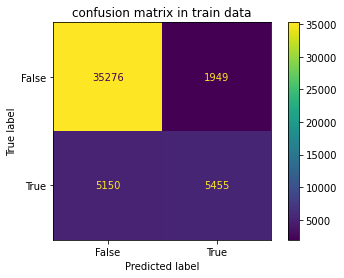

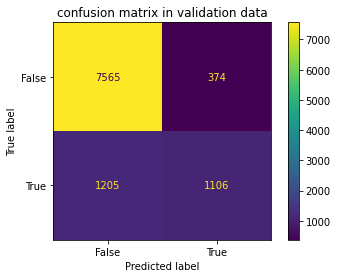

######################


In [45]:
best_layers = [128, 128]
best_activations = nn.ReLU()
all_batch_size = [4, 16, 128]
for batch_size in all_batch_size:
    print('batch size: ' + str(batch_size))
    model, train_loss, train_acc, val_loss, val_acc, train_conf, val_conf = train_model(dataset=dataset, activations=[activation for _ in range(len(best_layers))], hidden_dims=best_layers, num_epochs=3, batch_size=batch_size)
    plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf, val_conf)
    print("######################")


#### Over fitting

epoch 29: 100%|██████████| 374/374 [00:17<00:00, 21.72it/s, train loss=0.0912, train acc=0.964, val loss=0.931, val acc=0.819]


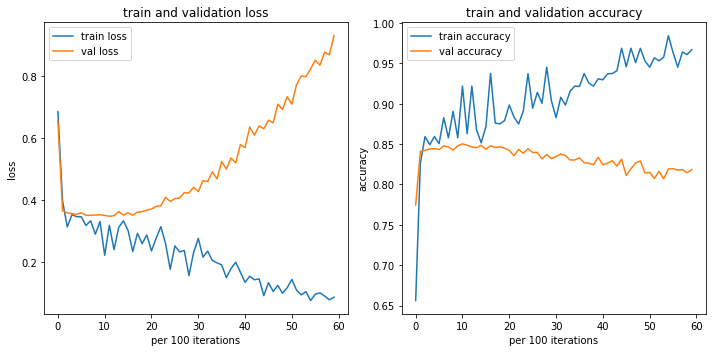

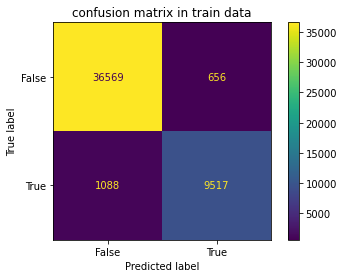

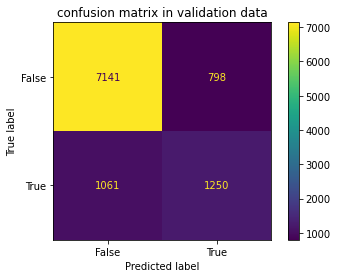

In [47]:
model, train_loss, train_acc, val_loss, val_acc, train_conf, val_conf = train_model(dataset=dataset, activations=[nn.ReLU(), nn.ReLU(), nn.ReLU()], hidden_dims=[128, 256, 128], num_epochs=30, batch_size=128)
plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf, val_conf)

#### Generalization

epoch 3: 100%|██████████| 374/374 [00:18<00:00, 20.37it/s, train loss=0.373, train acc=0.839, val loss=0.369, val acc=0.84]


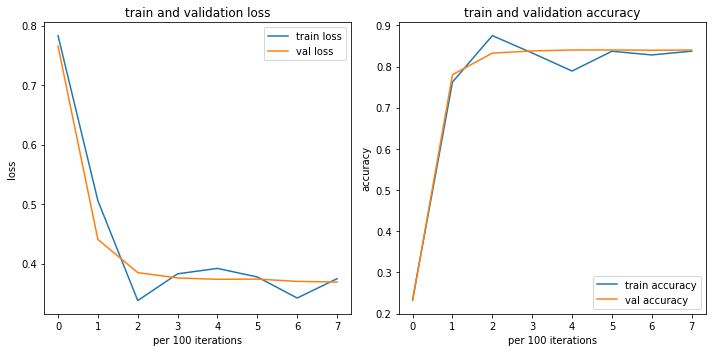

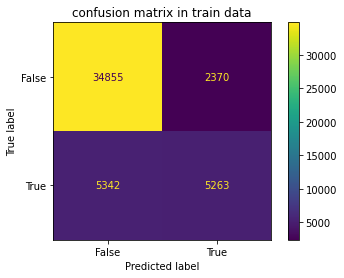

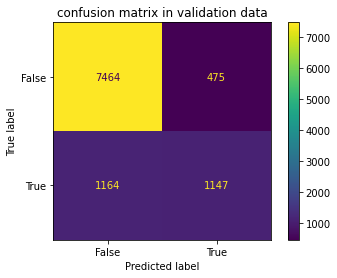

test loss: 0.37883229756060943
test accuracy: 0.8420333691091814


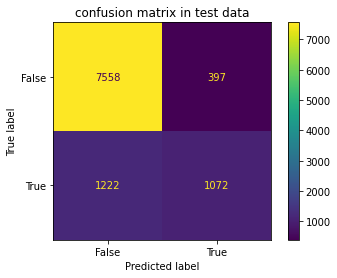

In [49]:
model, train_loss, train_acc, val_loss, val_acc, train_conf, val_conf = train_model(dataset=dataset, activations=[nn.Sigmoid(), None, nn.Sigmoid(), None], hidden_dims=[64, 0, 64, 0], num_epochs=4, batch_size=128)
plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf, val_conf)

test_loss, test_acc, confusion_mat = test_model(model, dataset, batch_size)
plot_test_info(test_loss, test_acc, confusion_mat)